In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import random
import resnet

from tensorflow.keras.layers import Input, Conv2D, Lambda, Conv2DTranspose,  BatchNormalization, Dense, Flatten,MaxPooling2D,Dropout, UpSampling2D,GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [36]:
def image_generator(path, dist = None, batch_size = 64, latent_dim = 1024):
    
    while True:
          # Select files (paths/indices) for the batch
            
        files = os.listdir(path)
#         batch_paths  = np.random.choice(a = files, 
#                                           size = int(batch_size/2))
        batch_in1  = list(np.zeros(int(batch_size/2)))
        batch_in2  = list(np.zeros(int(batch_size/2)))
        batch_output = np.zeros((batch_size, latent_dim))
          
          # Read in each input, perform preprocessing and get labels
        for i in range(len(batch_in1)):
            cond = True
            while cond:
                try:
                    input_path = random.choice(files)
#                     print(input_path)
#                     print(input_path)
                    img = imageio.imread(path + '/' + input_path)
                    if dist == None:
                        batch_in1[i], batch_in2[i] = img,img
                    else:
                        batch_in1[i], batch_in2[i] = dist.random_transform(img),dist.random_transform(img)
                    cond = False
                except:
                    cond = True
            
            
            
        batch_input = batch_in1 + batch_in2
            
          # Return a tuple of (input, output) to feed the network
        batch_x = np.array( batch_input )
#         print(batch_x.shape)
#         batch_x = batch_x.reshape(batch_size, batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])
        
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [61]:
x, y = aug.send(None)

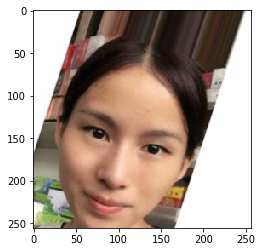

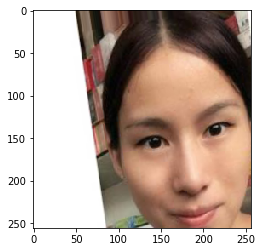

In [62]:
ind = 0

plt.figure(0)
plt.imshow(x[ind])
plt.figure(1)
plt.imshow(x[ind + len(x)//2])

In [81]:
latent_dim = 128

build = resnet.ResnetBuilder()
res = build.build_resnet_18((256,256,3),1)

inputs = Input(shape = (256,256,3))
latent = res(inputs)
proj = Dense(latent_dim, activation = 'relu')(latent)
proj = Dense(latent_dim, activation = 'relu')(proj)
proj = Dense(latent_dim, activation = 'relu')(proj)
proj = Dense(latent_dim, activation = 'linear')(proj)

model = Model(inputs, proj)

In [82]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
model_8 (Model)              (None, 512)               11187328  
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
Total params: 11,302,528
Trainable params: 11,294,720
Non-trainable params: 7,808
___________________________________________

In [83]:
def contrastive_loss(true, hidden,
                         hidden_norm=True,
                         temperature=1.0,
                         tpu_context=None,
                         weights=1.0):
    """Compute loss for model.
      Args:
        hidden: hidden vector (`Tensor`) of shape (bsz, dim).
        hidden_norm: whether or not to use normalization on the hidden vector.
        temperature: a `floating` number for temperature scaling.
        tpu_context: context information for tpu.
        weights: a weighting number or vector.
      Returns:
        A loss scalar.
        The logits for contrastive prediction task.
        The labels for contrastive prediction task.
      """
  # Get (normalized) hidden1 and hidden2.

    LARGE_NUM = 1e9

    if hidden_norm:
        hidden = tf.math.l2_normalize(hidden, -1)
    hidden1, hidden2 = tf.split(hidden, 2, 0)
    batch_size = tf.shape(hidden1)[0]

  # Gather hidden1/hidden2 across replicas and create local labels.

    
    hidden1_large = hidden1
    hidden2_large = hidden2
    labels = tf.one_hot(tf.range(batch_size), batch_size * 2)
    masks = tf.one_hot(tf.range(batch_size), batch_size)

    logits_aa = tf.matmul(hidden1, hidden1_large, transpose_b=True) / temperature
    logits_aa = logits_aa - masks * LARGE_NUM
    logits_bb = tf.matmul(hidden2, hidden2_large, transpose_b=True) / temperature
    logits_bb = logits_bb - masks * LARGE_NUM
    logits_ab = tf.matmul(hidden1, hidden2_large, transpose_b=True) / temperature
    logits_ba = tf.matmul(hidden2, hidden1_large, transpose_b=True) / temperature

    loss_a = tf.nn.softmax_cross_entropy_with_logits(
      labels, tf.concat([logits_ab, logits_aa], 1))
    loss_b = tf.nn.softmax_cross_entropy_with_logits(
      labels, tf.concat([logits_ba, logits_bb], 1))
    loss = loss_a + loss_b

    return loss

In [86]:
optimizer=SGD(lr=0.01)
loss = contrastive_loss
metrics = []
model.compile(loss=loss,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=metrics)

In [87]:
cnt = 0
batch_size = 64
EPOCHS = 800


stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=6, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)


dist = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

aug = image_generator('./img_256',dist = dist, batch_size = batch_size, latent_dim = latent_dim)



X_test, y_test = aug.send(None)

model.fit_generator(aug, epochs=EPOCHS, steps_per_epoch=500,validation_data=(X_test, y_test),
             verbose=1, callbacks = [stop, reduce])

  ...
    to  
  ['...']
Train for 500 steps, validate on 64 samples
Epoch 1/800
500/500 [==============================] - 417s 834ms/step - loss: 7.1296 - val_loss: 7.1729
Epoch 2/800
500/500 [==============================] - 415s 830ms/step - loss: 7.1252 - val_loss: 7.1700
Epoch 3/800
500/500 [==============================] - 416s 832ms/step - loss: 7.1233 - val_loss: 7.1545
Epoch 4/800
500/500 [==============================] - 415s 829ms/step - loss: 7.1220 - val_loss: 7.1669
Epoch 5/800
136/500 [=======>......................] - ETA: 5:01 - loss: 7.1197

KeyboardInterrupt: 

In [92]:
def get_batch(n):
    files = os.listdir('./img_256')
    imgs = list(np.zeros(n))
    
    for i in range(n):
        file = random.choice(files)
        imgs[i] = imageio.imread('./img_256/'+file)
    return np.array(imgs)

In [165]:
batch = get_batch(10000)

In [166]:
batch.shape

(10000, 256, 256, 3)

In [167]:
# example of creating a face embedding
from keras_vggface.vggface import VGGFace
# create a vggface2 model
vgg = VGGFace(model='resnet50', include_top = False, input_shape = (256,256,3), pooling = 'avg')
# summarize input and output shape
print('Inputs: %s' % vgg.inputs)
print('Outputs: %s' % vgg.outputs)

Inputs: [<tf.Tensor 'input_16:0' shape=(None, 256, 256, 3) dtype=float32>]
Outputs: [<tf.Tensor 'global_average_pooling2d_2/Mean:0' shape=(None, 2048) dtype=float32>]


In [168]:
y_pred = vgg.predict(batch)

In [169]:
y_pred.shape

(10000, 2048)

In [170]:
def cosine(x, y):
    return (x*y).sum()/(np.sqrt((x*x).sum())*np.sqrt((y*y).sum()))

In [171]:
vgg.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 128, 128, 64) 9408        input_16[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 128, 128, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 128, 128, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [172]:
# batch = batch[:,:224,:224,:]

In [173]:
y_pred.shape

(10000, 2048)

[0.5178498  0.53244191 0.53244191 0.59731853 0.60718739]


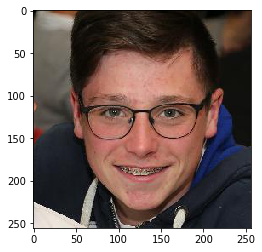

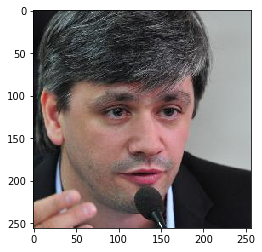

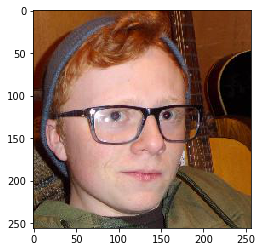

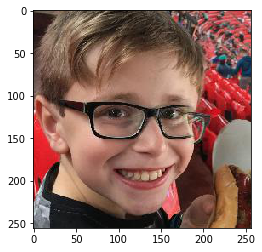

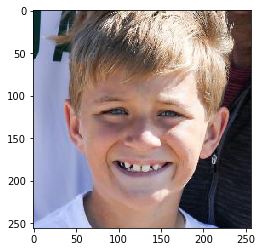

In [186]:
ind = 9


d = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if i != ind:
        d[i] = cosine(y_pred[i], y_pred[ind])
    else:
        d[i] = -1e9
        
a = np.argsort(d)[-5:]

print(d[a])

plt.figure(0)
plt.imshow(batch[ind])

for elt  in range(4):
    plt.figure(elt+1)
    plt.imshow(batch[a[-elt]])

In [187]:
import umap

In [190]:
reducer = umap.UMAP(n_neighbors=15, metric='cosine', n_components=2)

embedding = reducer.fit(y_pred)

y_pred1 = embedding.transform(y_pred)

C:\Users\gabri\Anaconda3\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


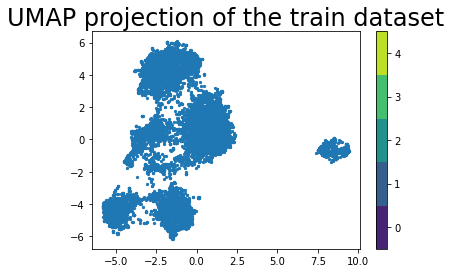

In [191]:
plt.figure(0)
plt.scatter(y_pred1[:, 0], y_pred1[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the train dataset', fontsize=24);

In [209]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters = 8, n_jobs = 10)
clf.fit(y_pred1)
clf.labels_

array([7, 0, 4, ..., 0, 6, 3])

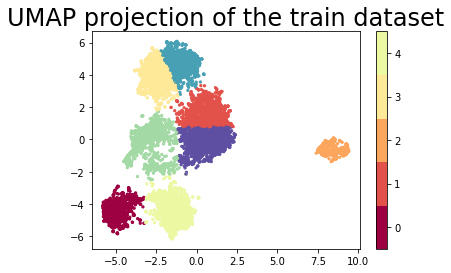

In [210]:
plt.figure(0)
plt.scatter(y_pred1[:, 0], y_pred1[:, 1], c = clf.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the train dataset', fontsize=24);

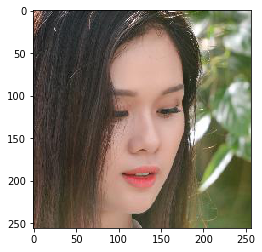

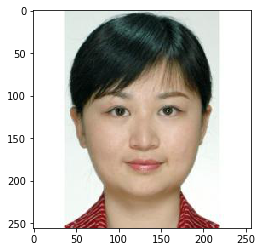

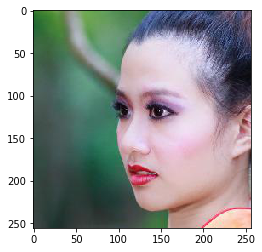

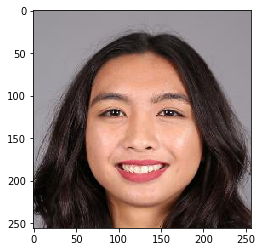

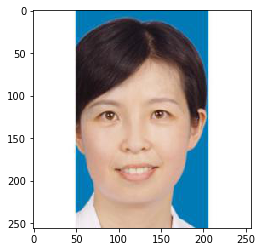

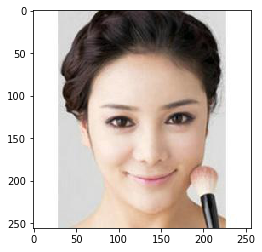

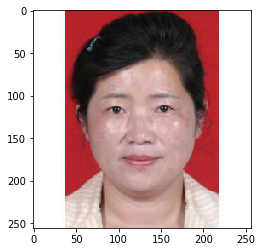

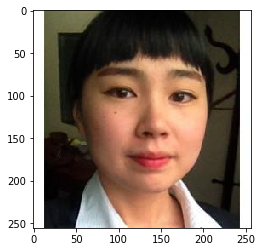

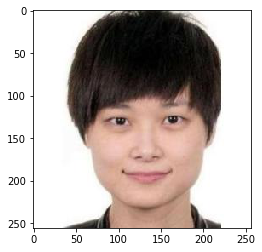

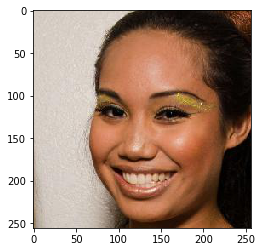

In [218]:
labels = clf.labels_


for i in range(10):

    im = batch[labels == 4][i]
    plt.figure(i)
    plt.imshow(im)